In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import copy
import math
import random
import json
import cv2
import sys
from matplotlib import pyplot as plt
import random
import time

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

def getFullClass():
	fullClass = {'Person':1, 'Laptop':2, 'Cat':3, 'Shotgun':4, 'Car':5, 'Human face':6, 'BG':7}
	return fullClass

def readJson(basePath = '/content/drive/My Drive/Colab Notebooks/'):
	with open(basePath+"dataInfo.json","r") as file:
		imgInfo = json.load(fp = file)
		imgList = []
		for key in imgInfo:
			imgList.append(imgInfo[key])
		return imgList

def augmentImg(singleImg,useAugment = True):
	imgData = copy.deepcopy(singleImg)
	img = cv2.imread(imgData['path'])

	if useAugment:
		rows,cols = img.shape[:2]

		if np.random.randint(0,2) == 0:
			img = cv2.flip(img,1)
			bboxesList = imgData['bboxes']
			for line in imgData['bboxes']:
				tempX = line[1]
				line[1] = cols - line[2]
				line[2] = cols - tempX

		if np.random.randint(0,2) == 0:
			img = cv2.flip(img,0)
			bboxesList = imgData['bboxes']
			for line in imgData['bboxes']:
				tempY = line[3]
				line[3] = rows - line[4]
				line[4] = rows - tempY

		rotAngle = np.random.choice([0, 90, 180, 270], 1)[0]

		if rotAngle == 0:
			pass

		if rotAngle == 90:
			img = np.transpose(img, (1,0,2))
			img = cv2.flip(img,1)
			for line in imgData['bboxes']:
				tempX1 = line[1]
				tempX2 = line[2]
				line[1] = rows - line[4]
				line[2] = rows - line[3]
				line[3] = tempX1
				line[4] = tempX2

		if rotAngle == 180:
			img = cv2.flip(img,-1)
			for line in imgData['bboxes']:
				tempX = line[2]
				tempY = line[4]
				line[2] = cols - line[1]
				line[1] = cols - tempX
				line[4] = rows - line[3]
				line[3] = rows - tempY

		if rotAngle == 270:
			img = np.transpose(img, (1,0,2))
			img = cv2.flip(img,0)
			for line in imgData['bboxes']:
				tempX1 = line[1]
				tempX2 = line[2]
				line[1] = line[3]
				line[2] = line[4]
				line[3] = cols - tempX2
				line[4] = cols - tempX1

	imgData['width'] = img.shape[1]
	imgData['height'] = img.shape[0]

	return imgData,img

def resizeImg(oriWidth,oriHeight,limit = 300):
	if oriWidth <= oriHeight:
		div = float(limit) / oriWidth
		outWidth = limit
		outHeight = int(oriHeight * div)
	else:
		div = float(limit) / oriHeight
		outWidth = int(oriWidth * div)
		outHeight = limit

	return outWidth,outHeight

def calcIoU(regionA,regionB):
	if regionA[0] > regionA[2] or regionA[1] > regionA[3] or regionB[0] > regionB[2] or regionB[1] > regionB[3]:
		return 0.0
		
	xLeft = max(regionA[0], regionB[0])
	xRight = min(regionA[2], regionB[2])
	yTop = max(regionA[1], regionB[1])
	yBottom = min(regionA[3], regionB[3])

	if xRight < xLeft or yBottom < yTop:
		return 0.0

	intersec = (xRight - xLeft) * (yBottom - yTop)

	areaA = (regionA[2] - regionA[0]) * (regionA[3] - regionA[1])
	areaB = (regionB[2] - regionB[0]) * (regionB[3] - regionB[1])

	union = areaA + areaB - intersec

	return float(intersec) / float(union + 1e-6)
	
def calcAnchors(imgData,width,height,resizeWidth,resizeHeight,shrinkFactor = 16):
	minIoU = 0.3
	maxIoU = 0.7
	anchorNum = 9
	anchorSize = [64,128,256]
	anchorRatio = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
	outWidth = resizeWidth // shrinkFactor
	outHeight = resizeHeight // shrinkFactor
	shrinkFactor = float(shrinkFactor)

	anc_obj = np.zeros((outHeight, outWidth, anchorNum))
	anc_valid = np.zeros((outHeight, outWidth, anchorNum))
	anc_regr = np.zeros((outHeight, outWidth, anchorNum * 4))

	boxNum = len(imgData['bboxes'])
	
	bboxesAnchorNum = np.zeros(boxNum).astype(int)
	bestAnchor = -1 * np.zeros((boxNum, 4)).astype(int)
	bestIoU = np.zeros(boxNum).astype(np.float32)
	bestBoxRegr = np.zeros((boxNum, 4)).astype(np.float32)

	groudTruthAnchor = np.zeros((boxNum, 4))
	
	index = 0
	for item in imgData['bboxes']:
		groudTruthAnchor[index,0] = item[1] * (resizeWidth / float(width))
		groudTruthAnchor[index,1] = item[2] * (resizeWidth / float(width))
		groudTruthAnchor[index,2] = item[3] * (resizeHeight / float(height))
		groudTruthAnchor[index,3] = item[4] * (resizeHeight / float(height))
		index += 1

	for size in range(len(anchorSize)):
		for ratio in range(len(anchorRatio)):
			anchorX = anchorSize[size] * anchorRatio[ratio][0]
			anchorY = anchorSize[size] * anchorRatio[ratio][1]

			for pixelX in range(outWidth):
				curX1 = shrinkFactor * (pixelX + 0.5) - anchorX / 2.0
				curX2 = shrinkFactor * (pixelX + 0.5) + anchorX / 2.0
				if curX1 < 0 or curX2 > resizeWidth:
					continue

				for pixelY in range(outHeight):
					curY1 = shrinkFactor * (pixelY + 0.5) - anchorY / 2.0
					curY2 = shrinkFactor * (pixelY + 0.5) + anchorY / 2.0
					if curY1 < 0 or curY2 > resizeHeight:
						continue
					bboxesType = 'false'
					bestPosIoU = 0.0

					for item in range(boxNum):
						regionA = [groudTruthAnchor[item,0], groudTruthAnchor[item,2], groudTruthAnchor[item,1], groudTruthAnchor[item,3]]
						regionB = [curX1,curY1,curX2,curY2]
						anchorIoU = calcIoU(regionA,regionB)

						if anchorIoU > bestIoU[item] or anchorIoU > maxIoU:
							groudTruthCenterX = (groudTruthAnchor[item,0] + groudTruthAnchor[item,1]) / 2.0
							groudTruthCenterY = (groudTruthAnchor[item,2] + groudTruthAnchor[item,3]) / 2.0
							anchorCenterX = (curX1 + curX2) / 2.0
							anchorCenterY = (curY1 + curY2) / 2.0

							tx = (groudTruthCenterX - anchorCenterX) / (curX2 - curX1)
							ty = (groudTruthCenterY - anchorCenterY) / (curY2 - curY1)
							tw = np.log((groudTruthAnchor[item,1] - groudTruthAnchor[item,0]) / (curX2 - curX1))
							th = np.log((groudTruthAnchor[item,3] - groudTruthAnchor[item,2]) / (curY2 - curY1))

						if anchorIoU > bestIoU[item]:
							bestAnchor[item] = [pixelY, pixelX, ratio, size]
							bestIoU[item] = anchorIoU
							bestBoxRegr[item,:] = [tx, ty, tw, th]
						
						if anchorIoU > maxIoU:
							bboxesType = 'true'
							bboxesAnchorNum[item] += 1
							if anchorIoU > bestPosIoU:
								bestPosIoU = anchorIoU
								bestPosRegr = (tx,ty,tw,th)

						if minIoU < anchorIoU < maxIoU:
							if bboxesType != 'true':
								bboxesType = 'neutral'

					if bboxesType == 'false':
						anc_valid[pixelY,pixelX,ratio + 3 * size] = 1
						anc_obj[pixelY,pixelX,ratio + 3 * size] = 0

					elif bboxesType == 'neutral':
						anc_valid[pixelY,pixelX,ratio + 3 * size] = 0
						anc_obj[pixelY,pixelX,ratio + 3 * size] = 0
					
					elif bboxesType == 'true':
						anc_valid[pixelY,pixelX,ratio+3 * size] = 1
						anc_obj[pixelY,pixelX,ratio+3 * size] = 1
						regrIndex = 4 * (ratio + 3 * size)
						anc_regr[pixelY,pixelX,regrIndex:regrIndex + 4] = bestPosRegr

	for index in range(bboxesAnchorNum.shape[0]):
		if bboxesAnchorNum[index] == 0:
			if bestAnchor[index,0] == -1:
				continue
			anc_valid[bestAnchor[index,0], bestAnchor[index,1], bestAnchor[index,2] + 3 * bestAnchor[index,3]] = 1
			anc_obj[bestAnchor[index,0], bestAnchor[index,1], bestAnchor[index,2] + 3 * bestAnchor[index,3]] = 1
			regrIndex = 4 * (bestAnchor[index,2] + 3 * bestAnchor[index,3])
			anc_regr[bestAnchor[index,0], bestAnchor[index,1], regrIndex:regrIndex + 4] = bestBoxRegr[index,:]
	
	anc_obj = np.transpose(anc_obj, (2,0,1))
	anc_obj = np.expand_dims(anc_obj, axis = 0)
	anc_valid = np.transpose(anc_valid, (2,0,1))
	anc_valid = np.expand_dims(anc_valid, axis = 0)
	anc_regr = np.transpose(anc_regr, (2,0,1))
	anc_regr = np.expand_dims(anc_regr,axis = 0)

	pos_anchor = np.where(np.logical_and(anc_obj[0, :, :, :] == 1, anc_valid[0, :, :, :] == 1))
	neg_anchor = np.where(np.logical_and(anc_obj[0, :, :, :] == 0, anc_valid[0, :, :, :] == 1))

	posAnchorNum = len(pos_anchor[0])

	limitAnchorNum = 256
	
	if len(pos_anchor[0]) > limitAnchorNum / 2:
		ignoreAnchor = random.sample(range(len(pos_anchor[0])), len(pos_anchor[0]) - limitAnchorNum / 2)
		anc_valid[0, pos_anchor[0][ignoreAnchor], pos_anchor[1][ignoreAnchor], pos_anchor[2][ignoreAnchor]] = 0
		posAnchorNum = limitAnchorNum/2

	if len(neg_anchor[0]) + posAnchorNum > limitAnchorNum:
		ignoreAnchor = random.sample(range(len(neg_anchor[0])), len(neg_anchor[0]) - posAnchorNum)
		anc_valid[0, neg_anchor[0][ignoreAnchor], neg_anchor[1][ignoreAnchor], neg_anchor[2][ignoreAnchor]] = 0
	
	rpn_Class = np.concatenate([anc_valid, anc_obj], axis = 1)
	rpn_Regr = np.concatenate([np.repeat(anc_obj, 4, axis = 1), anc_regr], axis = 1)
	return np.copy(rpn_Class),np.copy(rpn_Regr)

def applyRegr(anchorMatrix,regrInfo):
	try:
		x = anchorMatrix[0, :, :]
		y = anchorMatrix[1, :, :]
		w = anchorMatrix[2, :, :]
		h = anchorMatrix[3, :, :]

		tx = regrInfo[0, :, :]
		ty = regrInfo[1, :, :]
		tw = regrInfo[2, :, :]
		th = regrInfo[3, :, :]

		centerX = x + w / 2.
		centerY = y + h / 2.
		centerX1 = tx * w + centerX
		centerY1 = ty * h + centerY

		w1 = np.exp(tw.astype(np.float64)) * w
		h1 = np.exp(th.astype(np.float64)) * h
		x1 = centerX1 - w1 / 2.
		y1 = centerY1 - h1 / 2.

		x1 = np.round(x1)
		y1 = np.round(y1)
		w1 = np.round(w1)
		h1 = np.round(h1)

		return np.stack([x1,y1,w1,h1])

	except Exception as e:
		print(e)
		return anchorMatrix

def non_max_suppression_fast(boxes, probs, overlap_threshold = 0.7, max_boxes = 300):
	if len(boxes) == 0:
		return []

	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	np.testing.assert_array_less(x1, x2)
	np.testing.assert_array_less(y1, y2)

	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	pick = []
	area = (x2 - x1) * (y2 - y1)
	idxs = np.argsort(probs)

	while len(idxs) > 0:
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		xx1_int = np.maximum(x1[i], x1[idxs[:last]])
		yy1_int = np.maximum(y1[i], y1[idxs[:last]])
		xx2_int = np.minimum(x2[i], x2[idxs[:last]])
		yy2_int = np.minimum(y2[i], y2[idxs[:last]])

		ww_int = np.maximum(0, xx2_int - xx1_int)
		hh_int = np.maximum(0, yy2_int - yy1_int)

		area_int = ww_int * hh_int
		area_union = area[i] + area[idxs[:last]] - area_int
		overlap = area_int/(area_union + 1e-6)

		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlap_threshold)[0])))

		if len(pick) >= max_boxes:
			break

	boxes = boxes[pick].astype("int")
	probs = probs[pick]
	return boxes

def proposalCreator(rpn_class, rpn_regr, max_boxes = 300, overlap_threshold = 0.7):
	shrinkFactor = 16.0
	shrinkFactor = float(shrinkFactor)
	stdevScaleFactor = 4.0

	rpn_regr = rpn_regr / stdevScaleFactor
	anchorSize = [64,128,256]
	anchorRatio = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
	
	(rows,cols) = rpn_class.shape[1:3]
	curLayer = 0

	anchorMatrix = np.zeros((4, rpn_class.shape[1], rpn_class.shape[2], rpn_class.shape[3]))

	for size in range(len(anchorSize)):
		for ratio in range(len(anchorRatio)):
			anchorX = (anchorSize[size] * anchorRatio[ratio][0]) / shrinkFactor
			anchorY = (anchorSize[size] * anchorRatio[ratio][1]) / shrinkFactor

			regrInfo = rpn_regr[0, :, :, 4 * curLayer:4 * curLayer + 4]
			regrInfo = np.transpose(regrInfo, (2, 0, 1))

			X,Y = np.meshgrid(np.arange(cols),np.arange(rows))

			anchorMatrix[0, :, :, curLayer] = X - anchorX / 2
			anchorMatrix[1, :, :, curLayer] = Y - anchorY / 2
			anchorMatrix[2, :, :, curLayer] = anchorX
			anchorMatrix[3, :, :, curLayer] = anchorY

			anchorMatrix[:, :, :, curLayer] = applyRegr(anchorMatrix[:, :, :, curLayer], regrInfo)

			anchorMatrix[2, :, :, curLayer] = np.maximum(1, anchorMatrix[2, :, :, curLayer])
			anchorMatrix[3, :, :, curLayer] = np.maximum(1, anchorMatrix[3, :, :, curLayer])

			anchorMatrix[2, :, :, curLayer] += anchorMatrix[0, :, :, curLayer]
			anchorMatrix[3, :, :, curLayer] += anchorMatrix[1, :, :, curLayer]

			anchorMatrix[0, :, :, curLayer] = np.maximum(0, anchorMatrix[0, :, :, curLayer])
			anchorMatrix[1, :, :, curLayer] = np.maximum(0, anchorMatrix[1, :, :, curLayer])
			anchorMatrix[2, :, :, curLayer] = np.minimum(cols - 1, anchorMatrix[2, :, :, curLayer])
			anchorMatrix[3, :, :, curLayer] = np.minimum(rows - 1, anchorMatrix[3, :, :, curLayer])

			curLayer += 1

	allAnchor = np.reshape(anchorMatrix.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))
	allProb = rpn_class.transpose((0, 3, 1, 2)).reshape((-1))

	illegalAnchor = np.where((allAnchor[:, 0] - allAnchor[:, 2] >= 0) | (allAnchor[:, 1] - allAnchor[:, 3] >= 0))

	allAnchor = np.delete(allAnchor, illegalAnchor, 0)
	allProb = np.delete(allProb, illegalAnchor, 0)

	result = non_max_suppression_fast(allAnchor, allProb, overlap_threshold = overlap_threshold, max_boxes = max_boxes)

	return result

def roiHead(anchorMatrix, imgData):
	shrinkFactor = 16.0
	shrinkFactor = float(shrinkFactor)
	width = imgData['width']
	height = imgData['height']
	resizeWidth,resizeHeight = resizeImg(width,height)

	boxNum = len(imgData['bboxes'])

	groudTruthAnchor = np.zeros((boxNum, 4))
	
	index = 0
	for item in imgData['bboxes']:
		groudTruthAnchor[index,0] = int(round(item[1] * (resizeWidth / float(width)) / shrinkFactor))
		groudTruthAnchor[index,1] = int(round(item[2] * (resizeWidth / float(width)) / shrinkFactor))
		groudTruthAnchor[index,2] = int(round(item[3] * (resizeHeight / float(height)) / shrinkFactor))
		groudTruthAnchor[index,3] = int(round(item[4] * (resizeHeight / float(height)) / shrinkFactor))
		index += 1

	roiList = []
	classInfo = []
	regrLabel = []
	regrCoord = []

	for index in range(anchorMatrix.shape[0]):
		(x1,y1,x2,y2) = anchorMatrix[index, :]
		x1 = int(round(x1))
		y1 = int(round(y1))
		x2 = int(round(x2))
		y2 = int(round(y2))

		bestPosIoU = 0.0
		best_bbox = -1
		for item in range(len(imgData['bboxes'])):
			regionA = [groudTruthAnchor[item,0], groudTruthAnchor[item,2], groudTruthAnchor[item,1], groudTruthAnchor[item,3]]
			regionB = [x1, y1, x2, y2]
			curIoU = calcIoU(regionA,regionB)

			if curIoU > bestPosIoU:
				bestPosIoU = curIoU
				best_bbox = item

		if bestPosIoU < 0.1:
			continue
		else:
			w = x2 - x1
			h = y2 - y1
			roiList.append([x1,y1,w,h])

			if 0.1 <= bestPosIoU < 0.5:
				className = 'BG'
				classNum = 7
			elif 0.5 <= bestPosIoU:
				classNum = imgData['bboxes'][best_bbox][0]

				groudTruthCenterX = (groudTruthAnchor[best_bbox,0] + groudTruthAnchor[best_bbox,1]) / 2.0
				groudTruthCenterY = (groudTruthAnchor[best_bbox,2] + groudTruthAnchor[best_bbox,3]) / 2.0
				anchorCenterX = x1 + w / 2.0
				anchorCenterY = y1 + h / 2.0

				tx = (groudTruthCenterX - anchorCenterX) / float(w)
				ty = (groudTruthCenterY - anchorCenterY) / float(h)
				tw = np.log((groudTruthAnchor[best_bbox,1] - groudTruthAnchor[best_bbox,0]) / float(w))
				th = np.log((groudTruthAnchor[best_bbox,3] - groudTruthAnchor[best_bbox,2]) / float(h))
			else:
				raise RuntimeError

		classDict = getFullClass()
		classLabel = len(classDict) * [0]
		classLabel[classNum - 1] = 1
		classInfo.append(copy.deepcopy(classLabel))
		coords = [0] * 4 * (len(classDict) - 1)
		labels = [0] * 4 * (len(classDict) - 1)
		if classNum != 7:
			classNum = classNum - 1
			pos = 4 * classNum
			regrStd = [8.0, 8.0, 4.0, 4.0]
			coords[pos:pos + 4] = [tx * regrStd[0], ty * regrStd[1], tw * regrStd[2], th * regrStd[3]]
			labels[pos:pos + 4] = [1,1,1,1]
			regrCoord.append(copy.deepcopy(coords))
			regrLabel.append(copy.deepcopy(labels))
		else:
			regrCoord.append(copy.deepcopy(coords))
			regrLabel.append(copy.deepcopy(labels))

	if len(roiList) == 0:
		return None,None,None

	X2 = np.array(roiList)
	Y1 = np.array(classInfo)
	Y2 = np.concatenate([np.array(regrLabel),np.array(regrCoord)],axis=1)
	return np.expand_dims(X2,axis = 0), np.expand_dims(Y1,axis = 0), np.expand_dims(Y2,axis = 0)

def roiSelect(Y1,roiNum = 4):
	
	negSamples = np.where(Y1[0, :, -1] == 1)
	posSamples = np.where(Y1[0, :, -1] == 0)

	if len(negSamples) > 0:
		negSamples = negSamples[0]
	else:
		negSamples = []
	if len(posSamples) > 0:
		posSamples = posSamples[0]
	else:
		posSamples = []

	posNum = len(posSamples)

	if len(posSamples) < roiNum // 2:
		selectPos = posSamples.tolist()
	else:
		selectPos = np.random.choice(posSamples, roiNum // 2, replace=False).tolist()

	try:
		selectNeg = np.random.choice(negSamples, roiNum - len(selectPos), replace=False).tolist()
	except:
		selectNeg = np.random.choice(negSamples, roiNum - len(selectPos), replace=True).tolist()

	selectSamples = selectPos + selectNeg

	return copy.deepcopy(selectSamples), posNum

def getData(imgInfo,basePath = '/content/drive/My Drive/Colab Notebooks/',useAugment = True):

	while True:

		for imgData in imgInfo:
			try:
				if useAugment:
					imgData,img = augmentImg(imgData)
				else:
					imgData,img = augmentImg(imgData,useAugment = False)
				resizeWidth,resizeHeight = resizeImg(imgData['width'],imgData['height'])
				img = cv2.resize(img, (resizeWidth,resizeHeight), interpolation=cv2.cv2.INTER_CUBIC)
				try:
					rpn_Class,rpn_Regr = calcAnchors(imgData, imgData['width'], imgData['height'], resizeWidth, resizeHeight)
				except:
					continue

				img = img.astype(np.float32)
				channelMean = [103.939, 116.779, 123.68]

				img[:,:,0] = img[:,:,0] - channelMean[0]
				img[:,:,1] = img[:,:,1] - channelMean[1]
				img[:,:,2] = img[:,:,2] - channelMean[2]

				img = np.transpose(img, (2,0,1))
				img = np.expand_dims(img, axis=0)
				img = np.transpose(img, (0, 2, 3, 1))

				stdevScaleFactor = 4.0
				rpn_Regr[:,rpn_Regr.shape[1]//2:, :, :] *= stdevScaleFactor

				rpn_Class = np.transpose(rpn_Class, (0, 2, 3, 1))
				rpn_Regr = np.transpose(rpn_Regr, (0, 2, 3, 1))

				yield np.copy(img),[np.copy(rpn_Class),np.copy(rpn_Regr)],imgData

			except Exception as e:
				print(e)
				continue



In [ ]:
def vgg16(input_tensor=None,trainable = False):

	inputImg = input_tensor

	x = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'block1_conv1')(inputImg)
	x = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'block1_conv2')(x)
	x = MaxPooling2D((2,2), strides = (2,2), name='block1_pool')(x)

	x = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'block2_conv1')(x)
	x = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'block2_conv2')(x)
	x = MaxPooling2D((2,2), strides = (2,2), name='block2_pool')(x)

	x = Conv2D(256,(3,3), activation = 'relu', padding = 'same', name = 'block3_conv1')(x)
	x = Conv2D(256,(3,3), activation = 'relu', padding = 'same', name = 'block3_conv2')(x)
	x = Conv2D(256,(3,3), activation = 'relu', padding = 'same', name = 'block3_conv3')(x)
	x = MaxPooling2D((2,2), strides = (2,2), name='block3_pool')(x)

	x = Conv2D(512,(3,3), activation = 'relu', padding = 'same', name = 'block4_conv1')(x)
	x = Conv2D(512,(3,3), activation = 'relu', padding = 'same', name = 'block4_conv2')(x)
	x = Conv2D(512,(3,3), activation = 'relu', padding = 'same', name = 'block4_conv3')(x)
	x = MaxPooling2D((2,2), strides = (2,2), name='block4_pool')(x)

	x = Conv2D(512,(3,3), activation = 'relu', padding = 'same', name = 'block5_conv1')(x)
	x = Conv2D(512,(3,3), activation = 'relu', padding = 'same', name = 'block5_conv2')(x)
	x = Conv2D(512,(3,3), activation = 'relu', padding = 'same', name = 'block5_conv3')(x)
	
	return x

def rpnLayer(baseLayer,anchorNum = 9):

	x = Conv2D(512, (3,3), activation = 'relu', padding= 'same', kernel_initializer='normal', name = 'rpn_conv1')(baseLayer)

	biclassX = Conv2D(anchorNum, (1,1), activation = 'sigmoid', kernel_initializer='uniform', name = 'rpn_out_class')(x)

	regrX = Conv2D(anchorNum * 4, (1,1), activation = 'linear', kernel_initializer='zero', name = 'rpn_out_regress')(x)

	return [biclassX,regrX,baseLayer]

class roiPooling(Layer):
	
	def __init__(self, pool_size, num_rois, **kwargs):
		self.pool_size = pool_size
		self.num_rois = num_rois

		super(roiPooling, self).__init__(**kwargs)

	def build(self, input_shape):
		self.nb_channels = input_shape[0][3]

	def compute_output_shape(self, input_shape):
		return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

	def call(self, x, maxk = None):
		img = x[0]
		roiList = x[1]

		input_shape = K.shape(img)
		resizeRoIList = []

		for index in range(self.num_rois):
			x = roiList[0, index, 0]
			y = roiList[0, index, 1]
			w = roiList[0, index, 2]
			h = roiList[0, index, 3]

			x = K.cast(x, 'int32')
			y = K.cast(y, 'int32')
			w = K.cast(w, 'int32')
			h = K.cast(h, 'int32')

			resizeRoI = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
			resizeRoIList.append(resizeRoI)

		output = K.concatenate(resizeRoIList, axis=0)
		output = K.reshape(output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))
		finalOutput = K.permute_dimensions(output, (0, 1, 2, 3, 4))

		return finalOutput

	def get_config(self):
		config = {'pool_size': self.pool_size,'num_rois': self.num_rois}
		base_config = super(roiPooling, self).get_config()
		return dict(list(base_config.items()) + list(config.items()))

def classifierLayer(baseLayer, roiInput, roiNum = 4, classNum = 7):

	pool_size = 7

	roiPoolingResult = roiPooling(pool_size,roiNum)([baseLayer, roiInput])

	x = TimeDistributed(Flatten(name = 'flatten'))(roiPoolingResult)

	x = TimeDistributed(Dense(4096, activation = 'relu', name = 'fc1'))(x)
	x = TimeDistributed(Dropout(0.5))(x)

	x = TimeDistributed(Dense(4096, activation = 'relu', name = 'fc2'))(x)
	result = TimeDistributed(Dropout(0.5))(x)

	resultClass = TimeDistributed(Dense(classNum, activation = 'softmax', kernel_initializer = 'zero'), name = 'dense_class_{}'.format(classNum))(result)

	resultRegr = TimeDistributed(Dense(4 * (classNum - 1), activation = 'linear', kernel_initializer = 'zero'), name = 'dense_regress_{}'.format(classNum))(result)

	return [resultClass,resultRegr]

def rpn_loss_regr(num_anchors):
	
	def rpn_loss_regr_fixed_num(y_true, y_pred):
		x = y_true[:, :, :, 4 * num_anchors:] - y_pred
		x_abs = K.abs(x)
		x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)
		return 1.0 * K.sum(
			y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(1e-4 + y_true[:, :, :, :4 * num_anchors])

	return rpn_loss_regr_fixed_num

def rpn_loss_cls(num_anchors):

	def rpn_loss_cls_fixed_num(y_true, y_pred):
			return 1.0 * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(1e-4 + y_true[:, :, :, :num_anchors])

	return rpn_loss_cls_fixed_num

def class_loss_regr(num_classes):
	def class_loss_regr_fixed_num(y_true, y_pred):
		x = y_true[:, :, 4*num_classes:] - y_pred
		x_abs = K.abs(x)
		x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
		return 1.0 * K.sum(y_true[:, :, :4 * num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(1e-4 + y_true[:, :, :4 * num_classes])
	return class_loss_regr_fixed_num

def class_loss_cls(y_true, y_pred):
	return 1.0 * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

def trainModel():
	imgList = readJson()
	random.seed(1)
	random.shuffle(imgList)
	trainData = getData(imgList)

	img_input = Input(shape=(None, None, 3))
	roi_input = Input(shape=(None, 4))

	anchorNum = 9
	classNum = 7

	vggLayer = vgg16(input_tensor = img_input, trainable = True)
	rpn = rpnLayer(vggLayer)
	classifier = classifierLayer(vggLayer,roi_input)

	model_rpn = Model(img_input, rpn[:2])
	model_classifier = Model([img_input,roi_input], classifier)
	model_all = Model([img_input,roi_input], rpn[:2] + classifier)

	modelPath = '/content/drive/My Drive/Colab Notebooks/model/'
	record_path = modelPath + 'record_vgg16.csv'

	if not os.path.isfile(modelPath + 'frcnn_vgg16.hdf5'):
		try:
			model_rpn.load_weights(modelPath + 'vgg16_weights_tf_dim_ordering_tf_kernels.h5', by_name=True)
			model_classifier.load_weights(modelPath + 'vgg16_weights_tf_dim_ordering_tf_kernels.h5', by_name=True)
			print('load weights success')
		except:
			print('load weights failed')
		record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
	else:
		model_rpn.load_weights(modelPath + 'frcnn_vgg16.hdf5', by_name=True)
		model_classifier.load_weights(modelPath + 'frcnn_vgg16.hdf5', by_name=True)

		record_df = pd.read_csv(record_path)

		r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
		r_class_acc = record_df['class_acc']
		r_loss_rpn_cls = record_df['loss_rpn_cls']
		r_loss_rpn_regr = record_df['loss_rpn_regr']
		r_loss_class_cls = record_df['loss_class_cls']
		r_loss_class_regr = record_df['loss_class_regr']
		r_curr_loss = record_df['curr_loss']
		r_elapsed_time = record_df['elapsed_time']
		r_mAP = record_df['mAP']

		print('Already train %dK batches'% (len(record_df)))

	optimizer = Adam(lr = 1e-5)
	optimizer_classifier = Adam(lr = 1e-5)
	model_rpn.compile(optimizer = optimizer, loss = [rpn_loss_cls(anchorNum), rpn_loss_regr(anchorNum)])
	model_classifier.compile(optimizer = optimizer_classifier, loss = [class_loss_cls, class_loss_regr(classNum - 1)], metrics={'dense_class_{}'.format(classNum): 'accuracy'})
	model_all.compile(optimizer = 'sgd', loss = 'mae')

	num_epochs = 40
	epoch_length = 2000
	iter_num = 0
	total_epochs = len(record_df) + num_epochs
	r_epochs = len(record_df)

	losses = np.zeros((epoch_length, 5))

	rpn_accuracy_rpn_monitor = []
	rpn_accuracy_for_epoch = []

	if len(record_df)==0:
		best_loss = np.Inf
	else:
		best_loss = np.min(r_curr_loss)
	
	start_time = time.time()
	for epochNum in range(num_epochs):

		progbar = generic_utils.Progbar(epoch_length)
		print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
		r_epochs += 1

		while True:
			try:
				if len(rpn_accuracy_rpn_monitor) == epoch_length:
					mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
					rpn_accuracy_rpn_monitor = []
					if mean_overlapping_bboxes == 0:
						print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

				X, Y, imgData = next(trainData)
				loss_rpn = model_rpn.train_on_batch(X,Y)
				proposal = model_rpn.predict_on_batch(X)
				roi = proposalCreator(proposal[0], proposal[1])
				X2, Y1, Y2 = roiHead(roi, imgData)
				if X2 is None:
					rpn_accuracy_rpn_monitor.append(0)
					rpn_accuracy_for_epoch.append(0)
					continue
				selectSamples,posNum = roiSelect(Y1)
				rpn_accuracy_rpn_monitor.append(posNum)
				rpn_accuracy_for_epoch.append(posNum)
				loss_class = model_classifier.train_on_batch([X, X2[:, selectSamples, :]], [Y1[:, selectSamples, :], Y2[:, selectSamples, :]])
				losses[iter_num, 0] = loss_rpn[1]
				losses[iter_num, 1] = loss_rpn[2]

				losses[iter_num, 2] = loss_class[1]
				losses[iter_num, 3] = loss_class[2]
				losses[iter_num, 4] = loss_class[3]

				iter_num += 1

				progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
									('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])

				if iter_num == epoch_length:
					loss_rpn_cls = np.mean(losses[:, 0])
					loss_rpn_regr = np.mean(losses[:, 1])
					loss_class_cls = np.mean(losses[:, 2])
					loss_class_regr = np.mean(losses[:, 3])
					class_acc = np.mean(losses[:, 4])

					mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
					rpn_accuracy_for_epoch = []

					print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
					print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
					print('Loss RPN classifier: {}'.format(loss_rpn_cls))
					print('Loss RPN regression: {}'.format(loss_rpn_regr))
					print('Loss Detector classifier: {}'.format(loss_class_cls))
					print('Loss Detector regression: {}'.format(loss_class_regr))
					print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
					print('Elapsed time: {}'.format(time.time() - start_time))
					elapsed_time = (time.time()-start_time)/60

					curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
					iter_num = 0
					start_time = time.time()

					if curr_loss < best_loss:
						best_loss = curr_loss
						model_all.save_weights(modelPath + 'frcnn_vgg16.hdf5')

					new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3),
							'class_acc':round(class_acc, 3), 
							'loss_rpn_cls':round(loss_rpn_cls, 3), 
							'loss_rpn_regr':round(loss_rpn_regr, 3), 
							'loss_class_cls':round(loss_class_cls, 3), 
							'loss_class_regr':round(loss_class_regr, 3), 
							'curr_loss':round(curr_loss, 3), 
							'elapsed_time':round(elapsed_time, 3), 
							'mAP': 0}

					record_df = record_df.append(new_row, ignore_index=True)
					record_df.to_csv(record_path, index=0)

					break
			except Exception as e:
				print(e)
				continue
	print('Train Complete!')

trainModel()


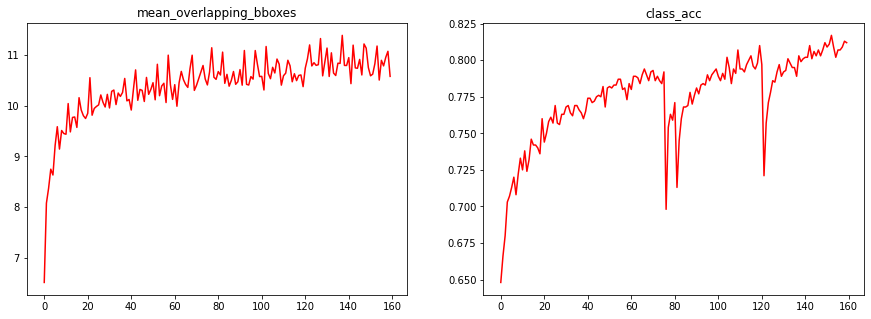

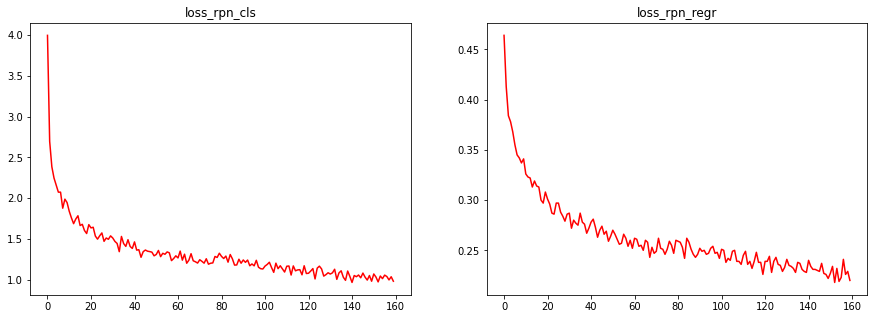

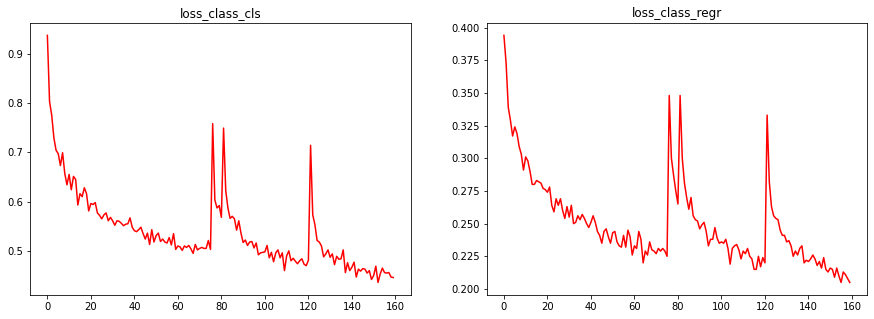

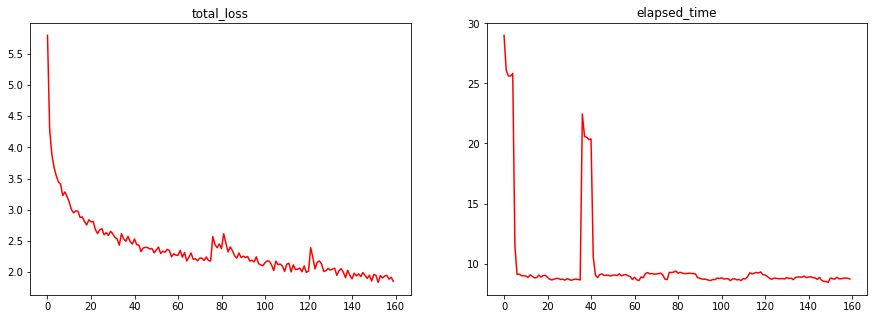

In [9]:
modelPath = '/content/drive/My Drive/Colab Notebooks/model/'
record_path = modelPath + 'record_vgg16.csv'

record_df = pd.read_csv(record_path)

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.show()